In [1]:
pip install pymilvus

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ragas

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load all required Libraries
import pandas as pd
import transformers, torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset

from pymilvus import MilvusClient, FieldSchema, CollectionSchema, DataType

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)


# Read Passages from the Datasets and Drop rows if they are NA or empty

In [4]:
passages = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/passages.parquet/part.0.parquet")

print(passages.shape)
passages.head()

(3200, 1)


,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


# Do EDA on the passage dataset
- You can try to find the maximum and minimum length of the passages before indexing (just a direction)

In [5]:
# Code for EDA

In [6]:
passages.head()

,passage
id,
0,"Uruguay (official full name in ; pron. , Eas..."
1,"It is bordered by Brazil to the north, by Arge..."
2,Montevideo was founded by the Spanish in the e...
3,The economy is largely based in agriculture (m...
4,"According to Transparency International, Urugu..."


Passage Length Statistics:


count    3200.000000
mean      389.848125
std       348.368869
min         1.000000
25%       108.000000
50%       299.000000
75%       574.000000
max      2515.000000
Name: passage_length, dtype: float64

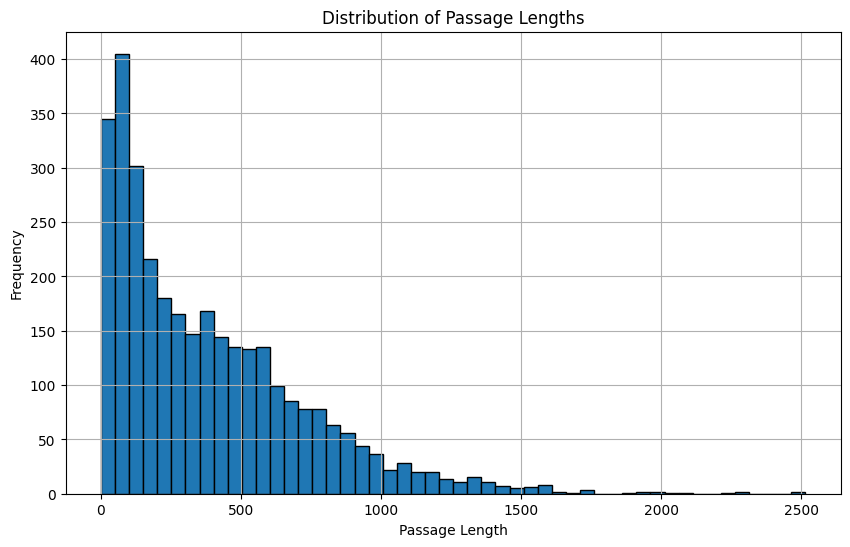


Passage with Minimum Length:
passage           |
passage_length    1
Name: 896, dtype: object

Passage with Maximum Length:
passage           As Ford approached his ninetieth year, he bega...
passage_length                                                 2515
Name: 2096, dtype: object


In [7]:
# Calculate the length of each passage
passages['passage_length'] = passages['passage'].apply(len)

# Display basic statistics of passage lengths
print("Passage Length Statistics:")
display(passages['passage_length'].describe())

# Plot a histogram of passage lengths
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(passages['passage_length'], bins=50, edgecolor='black')
plt.title('Distribution of Passage Lengths')
plt.xlabel('Passage Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Find the passage with the minimum length
min_length_passage = passages.loc[passages['passage_length'].idxmin()]
print("\nPassage with Minimum Length:")
print(min_length_passage)

# Find the passage with the maximum length
max_length_passage = passages.loc[passages['passage_length'].idxmax()]
print("\nPassage with Maximum Length:")
print(max_length_passage)

In [8]:
print(passages.iloc[0]['passage'])

Uruguay (official full name in  ; pron.  , Eastern Republic of  Uruguay) is a country located in the southeastern part of South America.  It is home to 3.3 million people, of which 1.7 million live in the capital Montevideo and its metropolitan area.


In [9]:
passages['passage'].isnull().sum()

np.int64(0)

# Tokenize Text and Generate Embeddings using Sentence Transformers

In [10]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode Text
embeddings = embedding_model.encode(passages['passage'].tolist())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Create Milvus Client and Insert your Embeddings to your DB
- Make sure you define a schema for your collection (Points will be deducted if you fail to define a proper schema with ids, passage text, embedding)

In [11]:
# Define every column of your schema

id_ = FieldSchema(name="id", dtype=DataType.INT64, is_primary=True)
passage = FieldSchema(name="passage", dtype=DataType.VARCHAR, max_length=65535)  # Adjust max_length as needed
embedding = FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=embeddings.shape[1])

In [12]:
schema = CollectionSchema(
    fields=[id_, passage, embedding],
    description="RAG Mini Wikipedia Collection"
)

In [16]:
pip install pymilvus\[milvus_lite\]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.4/24.4 MB 81.0 MB/s  0:00:00 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
client = MilvusClient("rag_wikipedia_mini.db")

# Create the Collection with Collection Name = "rag_mini". Make sure you define the schema variable while creating the collection
client.create_collection(collection_name="rag_mini", schema=schema)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**Convert your Pandas Dataframe to a list of dictionaries**
- The Dictionary at least have 3 keys [id, passage, embedding]

In [18]:
rag_data = passages.drop(columns=['passage_length']).reset_index().to_dict('records')

# Add the embeddings to the rag_data
for i, row in enumerate(rag_data):
    row['embedding'] = embeddings[i].tolist()

In [19]:
# Code to insert the data to your DB
res = client.insert(collection_name="rag_mini", data=rag_data)

print(res)

{'insert_count': 3200, 'ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,

- Do a Sanity Check on your database

**Do not delete the below line during your submission**

In [20]:
print("Entity count:", client.get_collection_stats("rag_mini")["row_count"])
print("Collection schema:", client.describe_collection("rag_mini"))

Entity count: 3200
Collection schema: {'collection_name': 'rag_mini', 'auto_id': False, 'num_shards': 0, 'description': 'RAG Mini Wikipedia Collection', 'fields': [{'field_id': 100, 'name': 'id', 'description': '', 'type': <DataType.INT64: 5>, 'params': {}, 'is_primary': True}, {'field_id': 101, 'name': 'passage', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 65535}}, {'field_id': 102, 'name': 'embedding', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}], 'functions': [], 'aliases': [], 'collection_id': 0, 'consistency_level': 0, 'properties': {}, 'num_partitions': 0, 'enable_dynamic_field': False}


# Steps to Fetch Results
- Read the Question Dataset
- Clean the Question Dataset if necessary (Drop Questions with NaN etc.)
- Convert Each Query to a Vector Embedding (Use the same embedding model you used to embed your document)
- Try for a Single Question First
- Load Collection into Memory after creating Index for Search on your embedding field (This is an essential step before you can search in your db)
- Search and Fetch Top N Results

In [21]:
import pandas as pd

queries = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-wikipedia/data/test.parquet/part.0.parquet")
queries

,question,answer
id,,
0,Was Abraham Lincoln the sixteenth President of...,yes
2,Did Lincoln sign the National Banking Act of 1...,yes
4,Did his mother die of pneumonia?,no
6,How many long was Lincoln's formal education?,18 months
8,When did Lincoln begin his political career?,1832
...,...,...
1710,Was Wilson president of the American Political...,Yes
1711,Did he not cast his ballot for John M. Palmer ...,Yes
1712,Did Wilson not spend 1914 through the beginnin...,Yes


In [22]:
query = queries['question'].iloc[0]                 # Your single query

query_embedding = embedding_model.encode(query)

print(query_embedding.shape)

(384,)


#### Create Index on the embedding column on your DB

In [23]:
index_params = MilvusClient.prepare_index_params()

# Add an index on the embedding field
index_params.add_index(
    field_name="embedding",
    index_type="AUTOINDEX",  # Or choose an appropriate index type like "IVF_FLAT", "HNSW"
    metric_type="COSINE"      # Or choose "L2" or "IP"
)

# Print the index parameters
print("Index parameters:", index_params)

# Create the index
try:
    client.create_index(collection_name="rag_mini", index_params=index_params)
    print("Index created successfully.")
except Exception as e:
    print(f"Index creation result: {e}")

# Load collection into memory (required for search)
client.load_collection("rag_mini")
print("Collection loaded into memory")

Index parameters: [{'field_name': 'embedding', 'index_type': 'AUTOINDEX', 'index_name': '', 'metric_type': 'COSINE'}]
Index created successfully.
Collection loaded into memory


In [24]:
# Search the db with your query embedding
output_ = client.search(
    collection_name="rag_mini",
    data=[query_embedding],      # Query embeddings
    limit=3,                     # Max search results to return
    output_fields=["passage"]    # Return the passage text
)

print(output_)

data: [[{'id': 288, 'distance': 0.7095189094543457, 'entity': {'passage': 'Young Abraham Lincoln'}}, {'id': 278, 'distance': 0.5840359926223755, 'entity': {'passage': 'Abraham Lincoln (February 12, 1809 â\x80\x93 April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that \'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in reference to the anti-expansion sentiments he had then expressed. Doris Kearns Goodwin, Team of Rivals: The Political Genius of Abraham Lincoln (2005) p. 91.  Holzer pg. 232.  Writing of the Cooper Union  speech, Holzer notes, "Cooper Union proved a unique confluence of political culture, rhetorical opportunity, te

## Now get the Context
- Initially use the first passage ONLY as your context
- In Later Experiments, you must try at least 2 different passage selection strategies (Top 3 / Top 5 / Top 10) and pass to your prompt

In [25]:
# Extract the passage text from the search results
context = "\n".join([hit['entity']['passage'] for hit in output_[0]])

**Develop your Prompt**

In [26]:
system_prompt = """You are a helpful assistant that answers questions based on the provided context.
If the answer is not found in the context, respond with "I don't know."
"""

prompt = f"""{system_prompt} \n Context: {context}: \n Question: {query} """
print(prompt)

You are a helpful assistant that answers questions based on the provided context.
If the answer is not found in the context, respond with "I don't know."
 
 Context: Young Abraham Lincoln
Abraham Lincoln (February 12, 1809 â April 15, 1865) was the sixteenth President of the United States, serving from March 4, 1861 until his assassination. As an outspoken opponent of the expansion of slavery in the United States, "[I]n his short autobiography written for the 1860 presidential campaign, Lincoln would describe his protest in the Illinois legislature as one that 'briefly defined his position on the slavery question, and so far as it goes, it was then the same that it is now." This was in reference to the anti-expansion sentiments he had then expressed. Doris Kearns Goodwin, Team of Rivals: The Political Genius of Abraham Lincoln (2005) p. 91.  Holzer pg. 232.  Writing of the Cooper Union  speech, Holzer notes, "Cooper Union proved a unique confluence of political culture, rhetorical op

# RAG Response for a Single Query

In [ ]:
# Load the LLM Model you want to use
model_name = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
# Generate answer
...

# Decode and extract answer.
...

Yes


# Generate Responses for all the Queries in the Dataset

In [ ]:
def generate_rag_response(query, client, embedding_model, tokenizer, model, collection_name="rag_mini", limit=3):
    """Generates a RAG response for a single query."""
    query_embedding = embedding_model.encode(query)

    # Search Milvus for relevant passages
    search_results = client.search(
        collection_name=collection_name,
        data=[query_embedding],
        limit=limit,
        output_fields=["passage"]
    )

    # Extract context from search results
    context = "\n".join([hit['entity']['passage'] for hit in search_results[0]])

    # Construct prompt
    system_prompt = """You are a helpful assistant that answers questions based on the provided context.
If the answer is not found in the context, respond with "I don't know."
"""
    prompt = f"""{system_prompt} \n Context: {context}: \n Question: {query} """

    # Generate answer using the LLM
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    outputs = model.generate(input_ids, max_length=512)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return answer, context

# Generate responses for all queries
rag_responses = []
contexts = []
for index, row in queries.iterrows():
    query = row['question']
    answer, context = generate_rag_response(query, client, embedding_model, tokenizer, model)
    rag_responses.append(answer)
    contexts.append([context]) # RAGAS expects contexts as a list of lists

# Add generated responses and contexts to the queries DataFrame
queries['generated_answer'] = rag_responses
queries['contexts'] = contexts

display(queries.head())

# Finding out the Basic QA Metrics (F1 score, EM score)

In [ ]:
# Your code Here
...

# Advanced Evaluation using RAGAs

In [ ]:
data = {
    "question": ... ,                     # Question
    "answer": ... ,                       # Generated Answer
    "contexts": ... ,                     # Context you pass in. You can just use top-1 here
    "ground_truths": ...                  # Reference Answer in the dataset (Human annotated)
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [ ]:
# Pass the dataset above to the evaluate method in RAGAs
# Your code here
...